# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [79]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Delete Packages
dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario2"
files = os.listdir(dir)
ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
     '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
     '.lis','.chd','.ddn','.sloc']
for file in files:
    for i in range(0,len(ext)):
        if file.endswith(ext[i]):
            os.remove(os.path.join(dir,file))

In [65]:
print(len(ext))

25


## 2. Discretization and other inputs

In [105]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

#dz = (ztop - zbot) / nlay #cell height in z direction
#print(dz)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone = np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
#print("recharge location forced(col, row)", rech_cols_forced,rech_rows_forced)

# rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
# rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
# rech_zone=np.zeros((1,nrow,ncol))
# rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
# print("recharge location(col, row)", rech_cols,rech_rows)

# Setting up well
pumping1 = 0 # m3/day      -1500 pumping rate for water supply well  
pumping2 = 0 # m^3/d         -3000 irrigation well pumping rate (for wheat)

well_1_xy= [38000, 21000] # xy location of aguaseca com well
well_1_row = np.floor((nrow-1)-(well_1_xy[1]/dy)) #convert the y location to a row (python row)
well_1_col=np.floor(well_1_xy[0]/dx-1) #convert the x location to a column
well_1_loc = [2,well_1_row,well_1_col, pumping1] #Well loc (layer, row, column)

well_2_xy= [14000, 12000] # xy location of irrigation well 
well_2_row = np.floor((nrow-1)-(well_2_xy[1]/dy)) #convert the y location to a row 
well_2_col=np.floor(well_2_xy[0]/dx-1) #convert the x location to a column
well_2_loc = [0,well_2_row,well_2_col, pumping2] #Well loc (layer, row, column)

MW1_xy =[25000, 25000] # xy location of monitoring well 1 
#MW1_row = np.floor((nrow-1)-(MW1_xy[1]/dy))  
#MW1_col=np.floor(MW1_xy[0]/dx-1) 
#MW1_loc = [0,MW1_row,MW1_col,0] 
MW1_loc = [0,25,25,0] 

MW2_xy = [12500, 12500] # xy location of smonitoring well 2 
MW2_row = np.floor((nrow-1)-(MW2_xy[1]/dy)) 
MW2_col=np.floor(MW2_xy[0]/dx-1) 
MW2_loc = [0,MW2_row,MW2_col,0] 

wel_spd = {0: [well_1_loc, well_2_loc, MW1_loc, MW2_loc]}
print(wel_spd)
## Boundary conditions
h_right = 70


## Timing
# nper = 1 #number of stress periods 
# steady = [True] #list noting the stress period type

{0: [[2, 28.0, 37.0, 0], [0, 37.0, 13.0, 0], [0, 26, 26, 0], [0, 36.0, 11.0, 0]]}


### Layering

In [106]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 




## Boundary Conditions

In [107]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0


np.set_printoptions(threshold=np.inf)


In [108]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

# Run Scenario 2 - Predevelopment Seasonality

Build the base model as described above without proposed agricultural activity 

Run the model as transient for 25 years with no pumping from the town's well. Recharge occurs at a constant rate all year, but ET takes place from April through September (inclusive) at the rate given in the problem description.

How long does it take for the model to reach a cyclical steady state (annual variations, but no trends)? Use monthly water levels at the monitoring wells to support your conclusion. This is the required 'burn in' time of your model.

### Setting up seasonality


In [109]:
#We start in October, because that's a water year
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 180       # Length of stress period 1 in days, October-March, no ET
sp2_len = 180      # Length of stress period 2 in days. April - September, regular ET
sim_years = 25       #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1) # total number of stress periods the +1 is for the steady state start
#here the total is (25*2)+1 = 51 stress periods
print (nper)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False # transient flag is false
steady[0] = True    # initial stress period is steady-state or true
print(steady)

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)#25 repeating sets of the two stress periods
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen*1
nstp[0]=1 #for the steady state solution we just want one output
print("Number of Steps", nstp)

51
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Period lengths [ 10 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180]
Number of Steps [  1 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180]


### Setting up seasonal ET

In [110]:
#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
ET = {} #set up an ET dictionary, where each key is a stress period num 0-50
ET_zone2 = ET_zone * 0 
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET[p] = ET_zone
    elif int(p % 2) != 0:
        ET[p]=ET_zone2
        #print(p)
    else: 
        ET[p] = ET_zone

## Set up and run scenario 2

In [111]:
#Initialize the model
modelname = "Scenario_2"
#moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp = nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

#Recharge 
# R = {}                                             # create empty dictionary for recharge fluxes
# for p in range(0,nper):                            # loop over stress periods, skipping initial steady state defined above
#     R[p]=rech_zone

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


# Attach ET package
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Setting up RIV package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

#Output control - OC 
oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
#print(np.shape(oc_spd))
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
#pcg = flopy.modflow.ModflowPcg(model=m)
#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=100, iter1=200, relax = 0.97, damp = 0.9)

#write the inputs
m.write_input()   
m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()
  

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative 

 Solving:  Stress period:     2    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    90    Ground-Wa

 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    23    Ground-Wa

 Solving:  Stress period:     3    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   147    Ground-Wa

 Solving:  Stress period:     4    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    88    Ground-Wa

 Solving:  Stress period:     5    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Wa

 Solving:  Stress period:     5    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   156    Ground-Wa

 Solving:  Stress period:     6    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    95    Ground-Wa

 Solving:  Stress period:     7    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    39    Ground-Wa

 Solving:  Stress period:     7    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   167    Ground-Wa

 Solving:  Stress period:     8    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   104    Ground-Wa

 Solving:  Stress period:     9    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    48    Ground-Wa

 Solving:  Stress period:     9    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   157    Ground-Wa

 Solving:  Stress period:    10    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    98    Ground-Wa

 Solving:  Stress period:    11    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    42    Ground-Wa

 Solving:  Stress period:    11    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   149    Ground-Wa

 Solving:  Stress period:    12    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    89    Ground-Wa

 Solving:  Stress period:    13    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    31    Ground-Wa

 Solving:  Stress period:    13    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   157    Ground-Wa

 Solving:  Stress period:    14    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    97    Ground-Wa

 Solving:  Stress period:    15    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    39    Ground-Wa

 Solving:  Stress period:    15    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   145    Ground-Wa

 Solving:  Stress period:    16    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    84    Ground-Wa

 Solving:  Stress period:    17    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    24    Ground-Wa

 Solving:  Stress period:    17    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   148    Ground-Wa

 Solving:  Stress period:    18    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    89    Ground-Wa

 Solving:  Stress period:    19    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    29    Ground-Wa

 Solving:  Stress period:    19    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   157    Ground-Wa

 Solving:  Stress period:    20    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    93    Ground-Wa

 Solving:  Stress period:    21    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    32    Ground-Wa

 Solving:  Stress period:    21    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   157    Ground-Wa

 Solving:  Stress period:    22    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    96    Ground-Wa

 Solving:  Stress period:    23    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    37    Ground-Wa

 Solving:  Stress period:    23    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   164    Ground-Wa

 Solving:  Stress period:    24    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   100    Ground-Wa

 Solving:  Stress period:    25    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    41    Ground-Wa

 Solving:  Stress period:    25    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   169    Ground-Wa

 Solving:  Stress period:    26    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   104    Ground-Wa

 Solving:  Stress period:    27    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    50    Ground-Wa

 Solving:  Stress period:    27    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   177    Ground-Wa

 Solving:  Stress period:    28    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   112    Ground-Wa

 Solving:  Stress period:    29    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    53    Ground-Wa

 Solving:  Stress period:    29    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   159    Ground-Wa

 Solving:  Stress period:    30    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    93    Ground-Wa

 Solving:  Stress period:    31    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    35    Ground-Wa

 Solving:  Stress period:    31    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   159    Ground-Wa

 Solving:  Stress period:    32    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    96    Ground-Wa

 Solving:  Stress period:    33    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    40    Ground-Wa

 Solving:  Stress period:    33    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   161    Ground-Wa

 Solving:  Stress period:    34    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    97    Ground-Wa

 Solving:  Stress period:    35    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    39    Ground-Wa

 Solving:  Stress period:    35    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   165    Ground-Wa

 Solving:  Stress period:    36    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   103    Ground-Wa

 Solving:  Stress period:    37    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    47    Ground-Wa

 Solving:  Stress period:    37    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   174    Ground-Wa

 Solving:  Stress period:    38    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   110    Ground-Wa

 Solving:  Stress period:    39    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    54    Ground-Wa

 Solving:  Stress period:    39    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   160    Ground-Wa

 Solving:  Stress period:    40    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    99    Ground-Wa

 Solving:  Stress period:    41    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    44    Ground-Wa

 Solving:  Stress period:    41    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   170    Ground-Wa

 Solving:  Stress period:    42    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   107    Ground-Wa

 Solving:  Stress period:    43    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    48    Ground-Wa

 Solving:  Stress period:    43    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   174    Ground-Wa

 Solving:  Stress period:    44    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   108    Ground-Wa

 Solving:  Stress period:    45    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    53    Ground-Wa

 Solving:  Stress period:    45    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   160    Ground-Wa

 Solving:  Stress period:    46    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   100    Ground-Wa

 Solving:  Stress period:    47    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    41    Ground-Wa

 Solving:  Stress period:    47    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   167    Ground-Wa

 Solving:  Stress period:    48    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   104    Ground-Wa

 Solving:  Stress period:    49    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    49    Ground-Wa

 Solving:  Stress period:    49    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   170    Ground-Wa

 Solving:  Stress period:    50    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   107    Ground-Wa

 Solving:  Stress period:    51    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    50    Ground-Wa

 Solving:  Stress period:    51    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   177    Ground-Wa

## Plotting Bounday Conditions

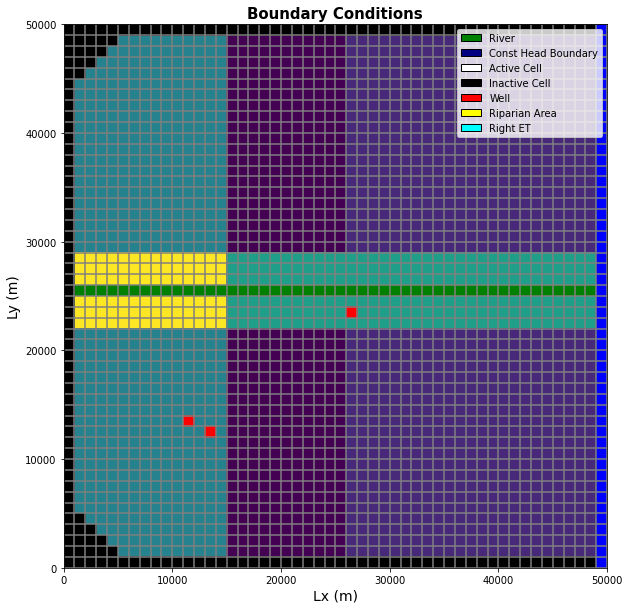

In [120]:
#CHECK BOUNDARY CONDITIONS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
zones = ET_zone + rech_zone
quadmesh = modelmap.plot_array(zones)
#recharge = modelmap.plot_array((rech_zone), color = 'orange')
#ET = modelmap.plot_array(ET_zone)
riv_plot = modelmap.plot_bc(ftype='RIV')
wel_plot = modelmap.plot_bc(ftype='WEL')
quadmesh = modelmap.plot_ibound()

#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                   mp.patches.Patch(color='navy',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='Red',label='Well',ec='black'),
                   mp.patches.Patch(color='Yellow',label='Riparian Area',ec='black'),
                   mp.patches.Patch(color='cyan',label='Right ET',ec='black')],)

## Read in the outputs

In [114]:
modelname = "Scenario_2"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps
#times2 = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]] 
#print(times2)

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per




## Plot head at monitoring wells

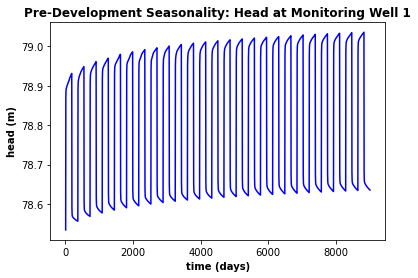

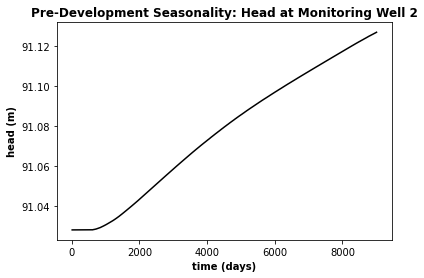

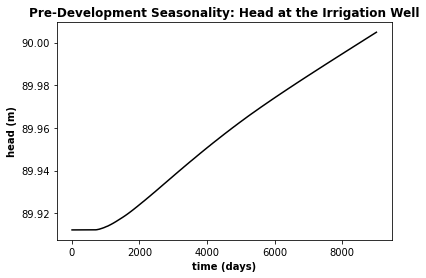

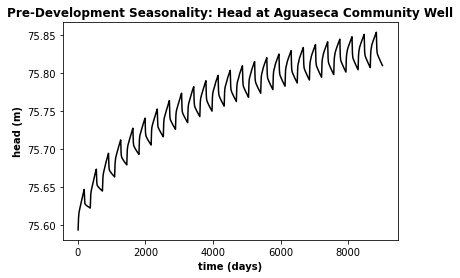

In [115]:
#plot a time series at both monitoring wells
#get time series for a certain cell
#print(well_loc)

cell_id1 = (0,25.0,25.0) #cell ID of MW1
cell_id2 = (0,36.0,11.0) #cell ID of MW2
ag_id = (0,37.0, 13.0)#cell ID of ag well
agua_id = (2, 28.0, 37.0) #Cell ID of aguaseca community well
time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well


#create plot of MW1
plt.subplot(1, 1, 1)
plt.title("Pre-Development Seasonality: Head at Monitoring Well 1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.show()

#create plot of MW2
plt.subplot(1, 1, 1)
plt.title("Pre-Development Seasonality: Head at Monitoring Well 2",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
plt.show()

#create plot of Ag well
plt.subplot(1, 1, 1)
plt.title("Pre-Development Seasonality: Head at the Irrigation Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
plt.show()

#create plot of Aguaseca com well
plt.subplot(1, 1, 1)
plt.title("Pre-Development Seasonality: Head at Aguaseca Community Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
plt.show()